# Sequence classification and generation using LSTMs

Adapted from: Practical PyTorch: Classifying Names with a Character-Level RNN, Generating Names with a Character-Level RNN

# Part 1: Sequence classification

We will be building and training a basic character-level RNN to classify words. A character-level RNN reads words as a series of characters - outputting a prediction and "hidden state" at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling:

```
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

# Preparing the Data

Included in the `data/names` directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We'll end up with a dictionary of lists of names per language, `{language: [names ...]}`. The generic variables "category" and "line" (for language and name in our case) are used for later extensibility.

In [18]:
import glob

all_filenames = glob.glob('data/05/names/*.txt')
print(all_filenames)

['data/05/names/Czech.txt', 'data/05/names/German.txt', 'data/05/names/Arabic.txt', 'data/05/names/Japanese.txt', 'data/05/names/Chinese.txt', 'data/05/names/Vietnamese.txt', 'data/05/names/Russian.txt', 'data/05/names/French.txt', 'data/05/names/Irish.txt', 'data/05/names/English.txt', 'data/05/names/Spanish.txt', 'data/05/names/Greek.txt', 'data/05/names/Italian.txt', 'data/05/names/Portuguese.txt', 'data/05/names/Scottish.txt', 'data/05/names/Dutch.txt', 'data/05/names/Korean.txt', 'data/05/names/Polish.txt']


In [19]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [20]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)

n_categories = 18


Now we have `category_lines`, a dictionary mapping each category (language) to a list of lines (names). We also kept track of `all_categories` (just a list of languages) and `n_categories` for later reference.

In [21]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# Turning Names into Tensors

Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

In [22]:
import torch

letter2idx = dict(zip(list(all_letters), list(range(n_letters))))

def line_to_idxs(line):
    return torch.tensor([letter2idx[letter] for letter in line], dtype=torch.long)

In [23]:
print(line_to_idxs('Jones'))

tensor([35, 14, 13,  4, 18])


# Network architecture

Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself. This means you can implement a RNN in a very "pure" way, as regular feed-forward layers.

<img src="images/05/classifier.png">

In [24]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class LSTMClassifier(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim

        # Input layer
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layer
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # Output layer
        # The linear layer that maps from hidden state space to tag space
        self.linear = nn.Linear(hidden_dim, num_classes)
        self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        hidden_init = (torch.zeros(1, 1, self.hidden_dim),
                       torch.zeros(1, 1, self.hidden_dim))
        self.hidden = hidden_init
        return hidden_init

    def forward(self, sentence):
        # Input representation
        embeds = self.word_embeddings(sentence)
        # Process sequence using LSTM
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden)
        # Output logits
        lstm_out = lstm_out[-1]
        logits = self.linear(lstm_out.view(1, -1))
        log_probs = F.log_softmax(logits, dim=1)
        return log_probs

# Preparing for Training

Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use `Tensor.topk` to get the index of the greatest value:

In [25]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(torch.randn(1, n_categories)))

('Arabic', tensor(2))


We will also want a quick way to get a training example (a name and its language):

In [26]:
import random

def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_idxs(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = German / line = Bottcher
category = Scottish / line = White
category = Polish / line = Zientek
category = Arabic / line = Ganem
category = Arabic / line = Gerges
category = German / line = Lohrenz
category = German / line = Wahner
category = Japanese / line = Kashiwagi
category = Portuguese / line = Salazar
category = Chinese / line = Rong


# Training the Network

Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it's wrong.

Define the model

In [27]:
n_hidden = 128
model = LSTMClassifier(n_hidden, n_hidden, n_letters, n_categories)

For the [loss function `nn.NLLLoss`](http://pytorch.org/docs/nn.html#nllloss) is appropriate, since the last layer of the RNN is `nn.LogSoftmax`.

In [28]:
criterion = nn.NLLLoss()

We will also create an "optimizer" which updates the parameters of our model according to its gradients. We will use the vanilla SGD algorithm with a low learning rate.

In [29]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Each loop of training will:

* Create input and target tensors
* Create a zeroed initial hidden state
* Read each letter in and
    * Keep hidden state for next letter
* Compare final output to target
* Back-propagate
* Return the output and loss

In [30]:
def train(targets, inputs):
    model.zero_grad()
    model.init_hidden()
    
    output = model(inputs)

    loss = criterion(output, targets)
    loss.backward()

    optimizer.step()

    return output, loss.data.item()

Now we just have to run that with a bunch of examples. Since the `train` function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every `print_every` time steps, and take an average of the loss.

In [31]:
import time
import math

n_epochs = 100000
print_every = 10000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

10000 10% (0m 26s) 2.0294 Santana / Spanish ✗ (Portuguese)
20000 20% (0m 52s) 4.5807 Holguin / Russian ✗ (Spanish)
30000 30% (1m 17s) 2.0616 Teteruk / Czech ✗ (Russian)
40000 40% (1m 43s) 1.1070 Borovsky / Russian ✗ (Czech)
50000 50% (2m 9s) 0.4483 Buiren / Dutch ✓
60000 60% (2m 36s) 0.6308 Koumans / Dutch ✓
70000 70% (3m 2s) 0.0018 Kanavos / Greek ✓
80000 80% (3m 27s) 0.6840 Blumenthal / German ✓
90000 90% (3m 53s) 0.0565 Taguchi / Japanese ✓
100000 100% (4m 19s) 0.0751 Nezvigin / Russian ✓


# Plotting the Results

Plotting the historical loss from `all_losses` shows the network learning:

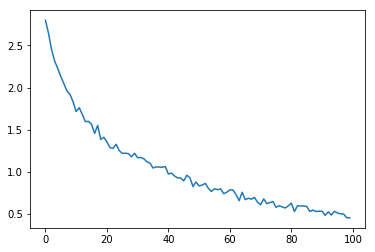

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating the Results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with `evaluate()`, which is the same as `train()` minus the backprop.

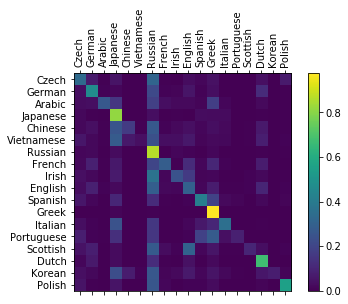

In [33]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):

    output = model(line_tensor)
    
    return output[-1].view(1, -1)

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

# Running on User Input

In [77]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_idxs(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky


IndexError: list index out of range

# Part 2: Sequence generation

In the previous part, you used RNNs to classify names into their language of origin. In this part you will use an RNN to generate names.

You already have the key ingredients for this part. We will add a few lines of code to the model we used in the previous part for this task. 
* We will add a start of sequence and end of sequence symbols to our vocabulary to indicate the beginning and end of the sequence. 
* We have a new objective function now. We have a loss for every time-step which involves predicting the next character given all the previous characters. 

<img src="images/05/lm.png">

In [35]:
letter2idx['<SOS>'] = n_letters
letter2idx['<EOS>'] = n_letters + 1

idx2letter = {value: key for key, value in letter2idx.items()}
    
def line_to_idxs(line):
    letter_idxs = [letter2idx[letter] for letter in line]
    letter_idxs = [letter2idx['<SOS>']] + letter_idxs + [letter2idx['<EOS>']]
    return torch.tensor(letter_idxs, dtype=torch.long)

In [36]:
class NameLM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes):
        super(NameLM, self).__init__()
        self.hidden_dim = hidden_dim

        # Input layer
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layer
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # Output layer
        # The linear layer that maps from hidden state space to tag space
        self.linear = nn.Linear(hidden_dim, num_classes)
        self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        self.hidden = (torch.zeros(1, 1, self.hidden_dim),
                       torch.zeros(1, 1, self.hidden_dim))

    def forward(self, sentence):
        
        # Input representation
        embeds = self.word_embeddings(sentence)
        
        # Process sequence using LSTM
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden)
        # Output logits
        logits = self.linear(lstm_out.view(len(sentence), -1))
        log_probs = F.log_softmax(logits, dim=1)
        return log_probs

In [37]:
model = NameLM(n_hidden, n_hidden, n_letters+2, n_letters+2)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(line_tensor[1:], line_tensor[:-1])
    current_loss += loss

    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        #guess, guess_i = category_from_output(output)
        #correct = '✓' if guess == category else '✗ (%s)' % category
        #print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))
        print('%d %d%% (%s) %.4f' % (epoch, epoch / n_epochs * 100, time_since(start), loss))
        

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

10000 10% (0m 31s) 2.6460
20000 20% (1m 2s) 2.2346
30000 30% (1m 32s) 2.9527
40000 40% (2m 1s) 2.7088
50000 50% (2m 30s) 2.7942
60000 60% (2m 59s) 1.9637
70000 70% (3m 29s) 2.3555
80000 80% (3m 58s) 1.9805
90000 90% (4m 27s) 1.9207
100000 100% (4m 56s) 1.8973


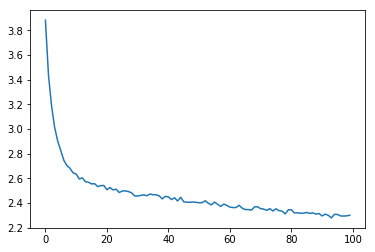

In [38]:
plt.figure()
plt.plot(all_losses)

# Sampling from the model

To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.
* Create tensors for input category, starting letter, and empty hidden state
* Create a string output_str with the starting letter
* Up to a maximum output length,
  * Feed the current letter to the network
  * Get the next letter from highest output, and next hidden state
  * If the letter is EOS, stop here
  * If a regular letter, add to output_str and continue
* Return the final name

In [101]:
max_length = 20

# Generate given a category and starting letter
def generate(start_chars='', temperature=0.5):
    
    model.init_hidden()
    
    start_char = '<SOS>'
    chars_input = letter2idx[start_char]

    output_str = ''
    
    for char in start_chars:
        chars_input = torch.tensor([chars_input])
        output = model(chars_input)
        chars_input = letter2idx[char]
        output_str += char
    
    for i in range(max_length):
        # output, hidden = model(category_input, chars_input[0], hidden)
        chars_input = torch.tensor([chars_input])
        output = model(chars_input)
        
        # Sample as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        sample_char_id = torch.multinomial(output_dist, 1).item()
        #sample_char_id = torch.argmax(output_dist).item()
        sample_char = idx2letter[sample_char_id]
        
        # Stop at EOS, or add to output_str
        if sample_char == '<EOS>':
            break
        else:
            output_str += sample_char
            chars_input = sample_char_id

    return output_str

In [194]:
generate()

'Koura'